In [160]:
import pandas as pd
import os.path as op
import numpy as np
from risk_experiment.utils import get_all_behavior, Subject
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
import seaborn as sns

def get_pdf(subject, session, bids_folder='/data/ds-risk', mask='npcr', n_voxels=100, old=False):
    
    if n_voxels == 0:
        key = 'decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space'

        if old:
            key += '.bak'

        # subject = f'{subject:02d}'

        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        key = 'decoded_pdfs.volume.denoise.natural_space'

        if old:
            key += '.bak'

        subject = f'{subject:02d}'

        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        return pd.read_csv(pdf, sep='\t', index_col=[0])
    else:
        print(pdf)
        return None

def get_decoding_info(subject, session, bids_folder='/data/ds-risk', mask='npcr', n_voxels=100, old=False):

    pdf = get_pdf(subject, session, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, old=old) 

    if pdf is not None:
        pdf.columns = pdf.columns.astype(float)

        E = (pdf*pdf.columns.values[np.newaxis, :] / pdf.sum(1).values[:, np.newaxis]).sum(1)
        E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

        E = pd.concat((E,), keys=[(subject, session, mask, n_voxels, old)],
        names=['subject', 'session', 'mask', 'n_voxels', 'old']).to_frame('E')

        E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

        return E
    else:
        return pd.DataFrame(np.zeros((0, 0)))

In [161]:
subjects = list(range(2, 33))
subjects.pop(subjects.index(24))
subjects = [f'{x:02d}' for x in subjects]
sessions = ['3t2', '7t2']
masks = ['npcl', 'npcr'][1:]
n_voxels = [0]
old = [False]

pred = []
pdfs = []
keys = []

for (sub, session, mask, nv, o) in product(subjects, sessions, masks, n_voxels, old):
    pred.append(get_decoding_info(sub, session, '/data/ds-risk', mask, nv, old=o))
    pdfs.append(get_pdf(sub, session, '/data/ds-risk', mask, nv, old=o))
    keys.append((sub, session, mask, nv, o))

pdfs = pd.concat(pdfs, keys=keys, names=['subject', 'session', 'mask', 'n_voxels', 'old'])
pred = pd.concat(pred)

  0%|          | 0/60 [00:00<?, ?it/s]

In [163]:
df = get_all_behavior(drop_no_responses=False, bids_folder='/data/ds-risk')
pred = pred.join(df, how='inner')

100%|██████████| 30/30 [00:01<00:00, 18.36it/s]


In [165]:
r1 = pred.groupby(['subject', 'session', 'mask', 'n_voxels', 'old']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2_ = pred.groupby(['subject', 'session', 'mask', 'n_voxels', 'run', 'old']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'session', 'mask', 'n_voxels', 'old']).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33251/2839759876.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'mask', 'n_voxels', 'old']).mean()


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


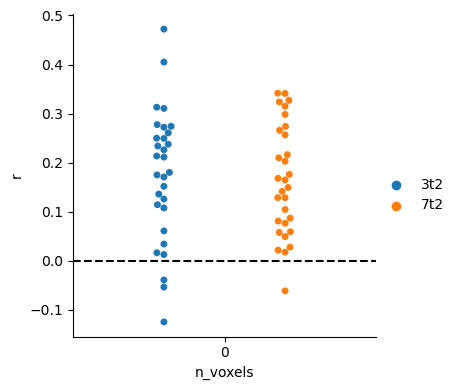

In [169]:
fac = sns.FacetGrid(data=r2.reset_index(), height=4)

fac.map(sns.swarmplot, 'n_voxels', 'r', 'session', palette=sns.color_palette()[:2], dodge=True)
fac.map(lambda *args, **kwargs: plt.axhline(0.0, c='k', ls='--'))

fac.add_legend()

In [171]:
pred['error'] = pred['n1'] - pred['E']
pred['abs(error)'] = np.abs(pred['error'])


r_error = pred.groupby(['subject', 'session', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['abs(error)']))

<Axes: >

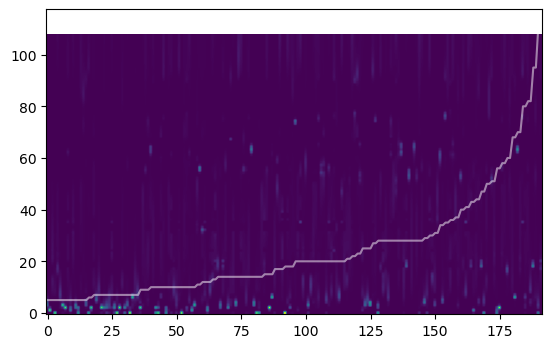

In [143]:
subject, session = 22, '3t2'
sub = Subject(subject, '/data/ds-risk')
pdf = get_pdf(subject, session, bids_folder='/data/ds-risk', mask='npcr', n_voxels=0, old=False)
decoding_info = get_decoding_info(subject, session, n_voxels=0)
behavior = sub.get_behavior(sessions=session)

tmp = behavior.reset_index(drop=True).sort_values('n1')
plt.imshow(pdf.iloc[tmp.index].T, origin='lower')

tmp.reset_index()['n1'].plot(c='white', alpha=.5)
# tmp['n1'].plot()

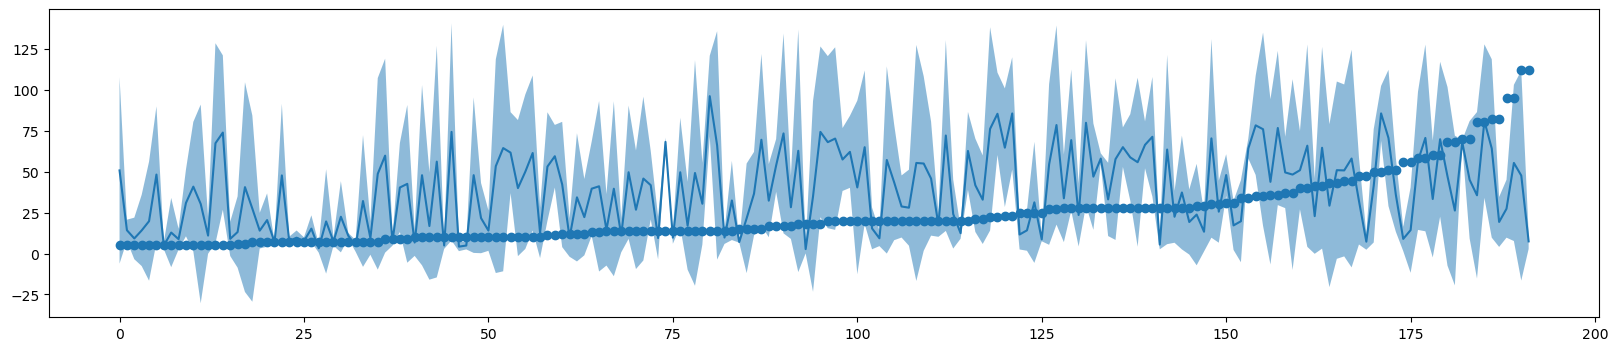

In [170]:
tmp = decoding_info.set_index(behavior['n1'], append=True)

tmp = tmp.sort_index(level='n1')

tmp['min'] = tmp['E'] - tmp['sd']*2
tmp['max'] = tmp['E'] + tmp['sd']*2

plt.plot(np.arange(192), tmp['E'])
plt.fill_between(np.arange(192), tmp['min'], tmp['max'], alpha=.5)
plt.scatter(np.arange(192), tmp.index.get_level_values('n1'), color=sns.color_palette()[0])

plt.gcf().set_size_inches(20, 4)

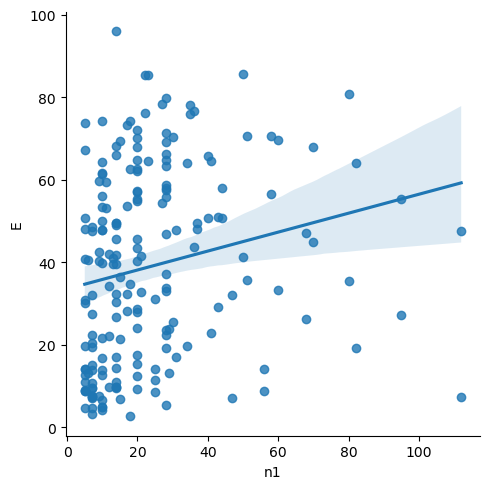

In [145]:
sns.lmplot(tmp.reset_index(), x='n1', y='E')